In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import colors

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BDeuScore

import seaborn as sns
import pandas as pd

import os
import pickle
import math

import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import networkx as nx

from tqdm import tqdm
from graphviz import Graph, Digraph

import itertools as it

%matplotlib inline

In [10]:
def plot_pair(pair,ax):
    fig = plt.figure(figsize=(3.5,4))
    
    ax = sns.violinplot(data=plot_data[pair],
                         cut=0, scale="width", palette=["blue", "red", "green"], ax=ax)
    ax.set(title=pair, ylim=(0,1), xticklabels=["Right", "No", "Left"])
    plt.close(fig)

    return fig

def calculate_avg_not_exists(item):
    return np.mean(item[1][:, 1])

def get_map(edge):
    data = plot_data[edge]
    probs = [np.mean(data[:, 0]), np.mean(data[:, 1]), np.average(data[:, 2])]
    direction = np.where(probs == np.amax(probs))
    
    return direction[0][0]

def graph_plot(edges, edgesun, filename, nodes):
    f = Digraph(filename, filename, format="png")
    f.attr(rankdir='LR',size='8,5')
    f.concentrate=True
    #overlap=True
    f.attr('node')
    for i in (nodes):
        f.node(i,color='black',shape='circle',style='filled',fillcolor='lightcyan')
            
    model = list(edges)
    for i in range(len(model)):
        f.node(model[i][0],color='black',shape='circle',style='filled',fillcolor='lightcyan')
        f.node(model[i][1],color='black',shape='circle',style='filled',fillcolor='lightcyan')
        f.edge(model[i][0],model[i][1])
    
    model = list(edgesun)
    for i in range(len(model)):
        f.node(model[i][0],color='black',shape='circle',style='filled',fillcolor='lightcyan')
        f.node(model[i][1],color='black',shape='circle',style='filled',fillcolor='lightcyan')
        f.edge(model[i][0],model[i][1], directed='True')

    f.view()   

In [11]:
official_edges = [('Smoking', 'Lung_Cancer'),
                ('Genetics', 'Lung_Cancer'),
                ('Genetics', 'Attention_Disorder'),
                ('Smoking', 'Yellow_Fingers'),
                ('Anxiety', 'Smoking'),
                ('Peer_Pressure', 'Smoking'),
                ('Allergy', 'Coughing'),
                ('Lung_Cancer', 'Coughing'),
                ('Coughing', 'Fatigue'),
                ('Lung_Cancer', 'Fatigue'),
                ('Fatigue', 'Car_Accident'),
                ('Attention_Disorder', 'Car_Accident')]

data = pd.read_csv('./lucas0.csv')
hc = HillClimbSearch(data)
hc_model = hc.estimate(scoring_method=BDeuScore(data))

bdeu = BDeuScore(pd.read_csv('./lucas0.csv'), equivalent_sample_size=5)
print(bdeu.score(hc_model))

  0%|          | 0/1000000 [00:00<?, ?it/s]

-6208.9173564287075


In [22]:
DIRECTORY = "./mcmc/"

possible_edges = [*filter(lambda x: ".pickle" in x and "pf" in x, os.listdir(DIRECTORY))]

plot_data = dict()

for possible_edge in tqdm(possible_edges):
    edge_name = possible_edge.split("mcmc_")[1].split(".pickle")[0]
    node1, node2 = edge_name.split("-")

    with open(DIRECTORY + possible_edge, 'rb') as handle:
        model = pickle.load(handle)
        plot_data[edge_name] = model["trace"]["frac"]

sorted_x = dict(sorted(plot_data.items(), key=calculate_avg_not_exists))

edges = list()
for key in sorted_x.keys():
    node_left, node_right = key.split("-")
    maxima = get_map(key)    
    
    if maxima == 0:
        edges.append((node_left, node_right))
        
    if maxima == 2:
        edges.append((node_right, node_left))
        
node_names = ('Smoking', 'Lung_Cancer', 'Genetics', 'Attention_Disorder', 
             'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Allergy', 'Coughing', 
             'Fatigue', 'Car_Accident', 'Born_an_Even_Day')

graph_plot(edges, [], '30_nets_1000_samples', node_names)

model_struct = BayesianNetwork(ebunch=edges)
model_struct.add_node("Born_an_Even_Day")
model_struct.nodes()
model_struct.fit(data=pd.read_csv('./lucas0.csv'), estimator=MaximumLikelihoodEstimator)

bdeu = BDeuScore(pd.read_csv('./lucas0.csv'), equivalent_sample_size=5)
print(bdeu.score(model_struct))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:11<00:00,  5.87it/s]


-6185.459245577078


66it [00:02, 26.33it/s]


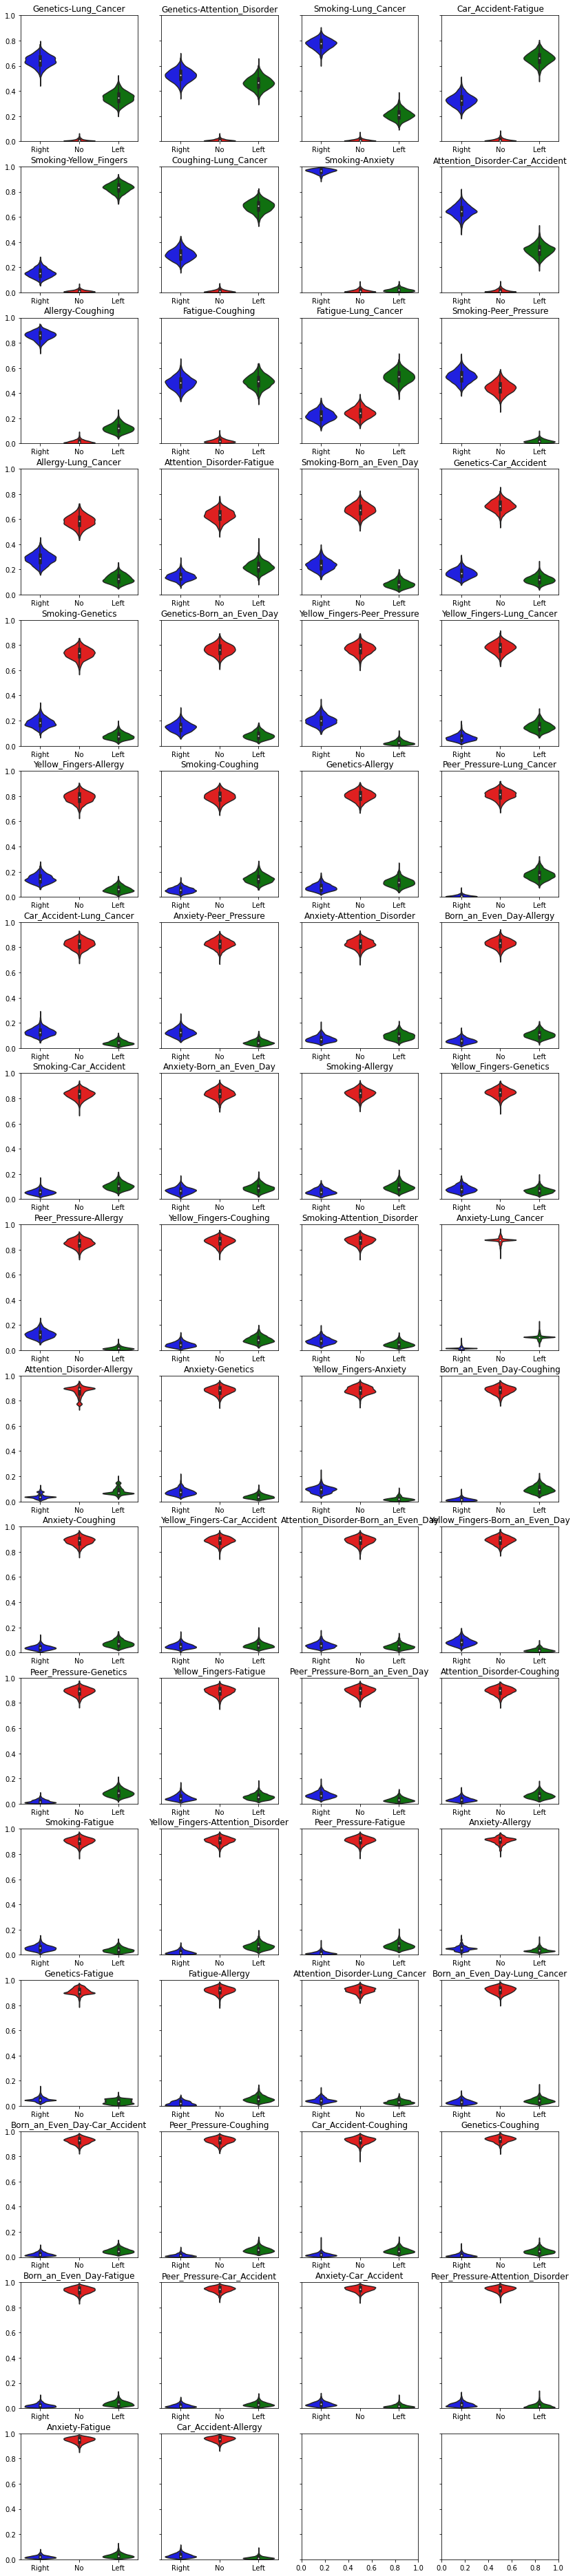

In [23]:
MAX_COLS = 4
LINES = max(2, math.ceil(len(plot_data.keys()) / MAX_COLS))

fig, axs = plt.subplots(LINES, MAX_COLS, figsize=(3.5*MAX_COLS, 4*LINES), sharey=True)

for i, key in tqdm(enumerate(sorted_x.keys())):
    k = plot_pair(key, axs[i//MAX_COLS][math.floor(i%MAX_COLS)])

1.0
[]


1.0
[]


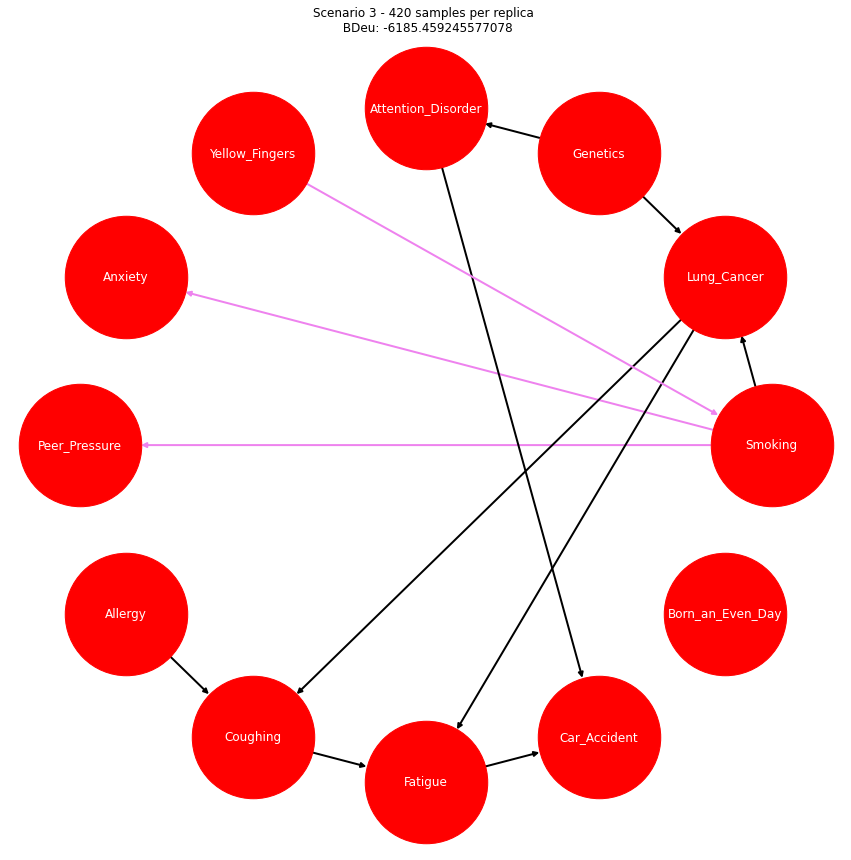

In [28]:
FP = []
FN = []
TP = []
TN = []

#evaluated_model = hc_model.edges()
evaluated_model = edges

for v0,v1 in it.combinations(data.columns, 2):
    edge = (v0, v1)
    inverse_edge = (v1, v0)
    
    if edge in evaluated_model or inverse_edge in evaluated_model:
        if edge in official_edges or inverse_edge in official_edges:
            TP.append(edge)
            
        else:
            FP.append(edge)
    
    else:
        if edge in official_edges or inverse_edge in official_edges:
            FN.append(edge)
            
        else:
            TN.append(edge)
            
MCC = (len(TP) * len(TN)) - (len(FP)*len(FN))
MCC = MCC / math.sqrt((len(TP)+len(FP)) * (len(TP)+len(FN)) * (len(TN)+len(FP)) * (len(TN)+len(FN)))

print(MCC)
print(FN)

digraph = nx.DiGraph()
digraph.add_nodes_from(node_names)

codes = list()
for edge in evaluated_model:
    if edge in official_edges:
        digraph.add_edge(edge[0], edge[1], color="black", style='-')
    elif (edge[1], edge[0]) in official_edges:
        digraph.add_edge(edge[0], edge[1], color="violet", style='-')
    else:    
        digraph.add_edge(edge[0], edge[1], color="orange", style='-')

fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.set_title("Scenario 3 - 420 samples per replica \n BDeu: "+ str(bdeu.score(digraph)))

for edge in FN:
    digraph.add_edge(edge[0], edge[1], color="lightgrey", style='--')

edges_names = digraph.edges()
colors = [digraph[u][v]['color'] for u,v in edges_names]

# Custom the nodes:
nx.draw(digraph, with_labels=True, node_color='red', font_color='white', node_size=15000, width=2.0,
    pos=nx.circular_layout(digraph), edge_color=colors, ax=ax)